<a href="https://colab.research.google.com/github/rubenguerra/datascience/blob/master/imagenesCTScans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Queremos entrenar un modelo que tome una imagen CT Scan y nos arroje como resultado si el paciente está sano o enfermo de neumonía

Usaremos una red convolucional 3D



In [ ]:
import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [ ]:

# Como vamos a trabajar con imágenes, haremos uso del acelerador de google GPU
dispositivo_acelerador=tf.config.experimental.list_physical_devices('GPU')
print('Num GPUs disponible: ', len(dispositivo_acelerador))
tf.config.experimental.set_memory_growth(dispositivo_acelerador[0], True)

Num GPUs disponible:  1


In [ ]:
# Bajando el dataset
url='https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip'
filename = os.path.join(os.getcwd(), 'CT-0.zip')
keras.utils.get_file(filename, url)

url='https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip'
filename=os.path.join(os.getcwd(), 'CT-23.zip')
keras.utils.get_file(filename, url)


1045168128/1045162547 [==============================] - 22s 0us/step


'/content/CT-23.zip'

In [ ]:
# Hacemos un directorio para guardar la data
os.makedirs('MosMedData')

In [ ]:
# Descomprimimos la data y la guardamos en el directorio creado
with zipfile.ZipFile('CT-0.zip', 'r') as z_fp:
  z_fp.extractall('./MosMedData/')

In [ ]:
with zipfile.ZipFile('CT-23.zip', 'r') as z_fp:
  z_fp.extractall('./MosMedData/')

# Cargamos la data y la preprocesamos
Los datos están en formato Nifti, con extensión .nii. Para leer las imagenes escaneadas usaremos el paquete nibabel.
Normalizamos estas imagenes entre -1000 y 400

Para procesar los datos:
* Rotamos los volumenes por 90°, la orientación es fijada
* Escalamos los valores HU entre 0 y 1
* Redimensionamos el ancho y altura y profundidad


In [ ]:
# Creamos algunas funciones para ayudarnos al procesamiento
import nibabel as nib

from scipy import ndimage

def read_nifti_file(filepath):
  "Lee y carga el volumen"
  #Lee archivo
  scan = nib.load(filepath)
  # Toma data
  scan = scan.get_fdata()
  return scan

def normalize(volume):
  "Normaliza el volumen"
  min = -1000
  max = 400
  volume[volume < min] = min
  volume[volume > max] = max
  volume = (volume - min) / (max - min)
  volume = volume.astype('float32')
  return volume

def resize_volume(img):
  "Redimensiona a través del eje Z"
  # Conjunto con la profundidad deseada
  desired_depth = 64
  desired_width = 128
  desired_height = 128

  # Toma profundidad
  current_depth = img.shape[-1]
  current_width = img.shape[0]
  current_height = img.shape[1]

  # Calcula el factor
  depth = current_depth / desired_depth
  width = current_width / desired_width
  height = current_height / desired_height

  depth_factor = 1 / depth
  width_factor = 1 / width
  height_factor = 1 / height

  #Rotación
  img = ndimage.rotate(img, 90, reshape=False)
  # Redimensionado a través de eje Z

  img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
  return img

def process_scan(path):
  "Lee el volumen y redimensiona"
  #Lee imagen
  volume = read_nifti_file(path)
  # Normaliza
  volume = normalize(volume)
  # Redimensiona
  volume = resize_volume(volume)
  return volume

Se lee las rutas a las imagenes CT scans de los directorios

In [ ]:
# La carpeta CT-0 contiene imágenes de pulmones en condiones normales, sin signos
# de neumonía

normal_scan_paths = [
                     os.path.join(os.getcwd(), 'MosMedData/CT-0', x)
                     for x in os.listdir('MosMedData/CT-0')
]

# La carpeta CT-23 contiene imágenes con pulmones opacos indicando neumonia
abnormal_scan_paths = [
                      os.path.join(os.getcwd(), 'MosMedData/CT-23', x)
                      for x in os.listdir('MosMedData/CT-23')
]

print('Imágenes CT scans con pulmones normales: ' + str(len(normal_scan_paths)))
print('Imágenes CT scans con pulmones enfermos ' + str(len(abnormal_scan_paths)))

Imágenes CT scans con pulmones normales: 100
Imágenes CT scans con pulmones enfermos 100


# Construyendo datasets de entrenamiento y validación
Se leen las imágenes y se les asigna etiquetas, y se divide el dataset para entrenamiento y validación

In [ ]:
abnormal_scan = np.array([process_scan(path) for path in abnormal_scan_paths])
normal_scan = np.array([process_scan(path) for path in normal_scan_paths])

# Para las imǵenes con presencia de neumonía viral
# se les asigna 1, o para las normales
abnormal_labels = np.array([1 for _ in range(len(abnormal_scan))])
normal_labels = np.array([0 for _ in range(len(normal_scan))])

# Dividimos la data en razón de 70-30 para entrenamiento  y validación
x_train = np.concatenate((abnormal_scan[:70], normal_scan[:70]), axis=0)
y_train = np.concatenate((abnormal_labels[:70], normal_labels[:70]), axis=0)
x_val = np.concatenate((abnormal_scan[70:], normal_scan[70:]), axis=0)
y_val = np.concatenate((abnormal_labels[70:], normal_labels[70:]), axis=0)

print('Número de ejemplos en entrenamiento y validación son %d y %d.' %(x_train.shape[0], x_val.shape[0]))

Número de ejemplos en entrenamiento y validación son 140 y 60.


# Aumento de la data

In [ ]:
import random
from scipy import ndimage

@tf.function
def rotate(volume):
  "Rota el volumen algunos grados"

  def scipy_rotate(volume):
    # Se definen algunos ángulos de rotación
    angles = [-20, -10, -5, 5, 10, 20]
    # Escoge angulos aleatoriamente
    angle = random.choice(angles)
    # Modifica el volumen
    volume = ndimage.rotate(volume, angle, reshape=False)
    volume[volume < 0] = 0
    volume[volume > 1] = 1
    return volume

  augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
  return augmented_volume

def train_preprocessing(volume, label):
  "Preprocesa el conjunto de entrenamiento por rotación y adición de un canal"
  # Rotación
  volume = rotate(volume)
  volume = tf.expand_dims(volume, axis=3)
  return volume, label

def validation_preprocessing(volume, label):
  "Preprocesa el conjunto de validación sólo adicionando un canal"
  volume = tf.expand_dims(volume, axis=3)
  return volume, label

In [ ]:
# Definiendo el cargador de datos
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

# Solo reescala
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

DImensión de la imagen es:  (128, 128, 64, 1)


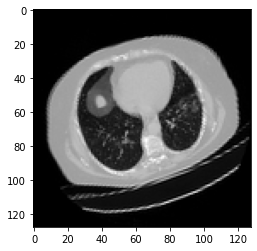

In [ ]:
# Visualizamos una imagen aumentada
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print('DImensión de la imagen es: ',image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap='gray')

ValueError: ignored

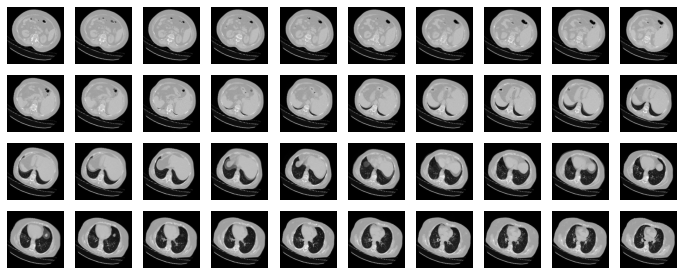

In [ ]:
# Dado que las imágenes tiene muchos deslizamientos, visualizamos un montaje de deslizamientos
def plot_slices(num_rows, num_columns, width, height, data):
  "Muestra de 20 imagenes"
  data = np.rot90(np.array(data))
  data = np.transpose(data)
  data = np.reshape(data, (num_rows, num_columns, width, height))
  rows_data, columns_data = data.shape[0], data.shape[1]
  heights = [slc[0].shape[0] for slc in data]
  widths = [slc.shape[1] for slc in data[0]]
  fig_width = 12.0
  fig_height = fig_width * sum(heights) / sum(widths)
  f, axarr = plt.subplots(
      rows_data,
      columns_data,
      figsize = (fig_width, fig_height),
      gridspec_kw={'height_ratios': heights},
  )
  for i in range(rows_data):
    for j in range(columns_data):
      axarr[i, j].imshow(data[i][j], cmap='gray')
      axarr[i, j].axis('off')
  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=0, bottom=0, top=1)
  plt.show()

#Visualiza un montaje de deslizamientos
# 4 filas y 10 columnas
plot_slices(4, 10, 128, 128, image[:,:,:40])

# Vamos a definir una red neuronal convolucional 3D

In [ ]:

def get_model(width=128, height=128, depth=64):
  inputs = keras.Input((width, height, depth, 1))

  x = layers.Conv3D(filters=64, kernel_size=3, activation='relu')(inputs)
  x = layers.MaxPool3D(pool_size=2)(x)
  x = layers.BatchNormalization()(x)

  x = layers.Conv3D(filters=64, kernel_size=3, activation='relu')(x)
  x = layers.MaxPool3D(pool_size=2)(x)
  x = layers.BatchNormalization()(x)

  x = layers.Conv3D(filters=128, kernel_size=3, activation='relu')(x)
  x = layers.MaxPool3D(pool_size=2)(x)
  x = layers.BatchNormalization()(x)

  x = layers.Conv3D(filters=256, kernel_size=3, activation='relu')(x)
  x = layers.MaxPool3D(pool_size=2)(x)
  x = layers.BatchNormalization()(x)

  x = layers.GlobalAveragePooling3D()(x)
  x = layers.Dense(units=512, activation='relu')(x)
  x = layers.Dropout(0.3)(x)

  outputs = layers.Dense(units=1, activation='sigmoid')(x)

  # Define el modelo
  modelo = keras.Model(inputs, outputs, name='3dcnn')
  return modelo

# Construye el modelo
modelo = get_model(width=128, height=128, depth=64)
modelo.summary()



Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 126, 126, 62, 64)  1792      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 63, 63, 31, 64)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 31, 64)    256       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 61, 61, 29, 64)    110656    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 30, 30, 14, 64)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 14, 64)    256   

# Entrenando el modelo

In [ ]:
# Compilando el modelo
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
modelo.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=['acc'],
)

# Define el callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    '3d_imagen_clasificacion.h5', save_bets_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_acc', patience=15)

# Entrenando el modelo, haciendo validación al final de cada epoch
epochs=100
modelo.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
70/70 - 30s - loss: 0.6834 - acc: 0.5429 - val_loss: 1.1053 - val_acc: 0.5000
Epoch 2/100
70/70 - 23s - loss: 0.6722 - acc: 0.5857 - val_loss: 1.2722 - val_acc: 0.5000
Epoch 3/100
70/70 - 23s - loss: 0.6382 - acc: 0.6643 - val_loss: 1.6516 - val_acc: 0.5000
Epoch 4/100
70/70 - 23s - loss: 0.6678 - acc: 0.6000 - val_loss: 2.1532 - val_acc: 0.5000
Epoch 5/100
70/70 - 22s - loss: 0.6233 - acc: 0.6429 - val_loss: 2.0120 - val_acc: 0.5000
Epoch 6/100
70/70 - 23s - loss: 0.6771 - acc: 0.6071 - val_loss: 0.8442 - val_acc: 0.5000
Epoch 7/100
70/70 - 22s - loss: 0.6365 - acc: 0.6571 - val_loss: 0.7059 - val_acc: 0.5000
Epoch 8/100
70/70 - 22s - loss: 0.6230 - acc: 0.6500 - val_loss: 0.8952 - val_acc: 0.5000
Epoch 9/100
70/70 - 23s - loss: 0.5951 - acc: 0.6857 - val_loss: 0.6929 - val_acc: 0.6000
Epoch 10/100
70/70 - 23s - loss: 0.6061 - acc: 0.6714 - val_loss: 0.5429 - val_acc: 0.7000
Epoch 11/100
70/70 - 22s - loss: 0.5961 - acc: 0.6786 - val_loss: 0.5978 - val_acc: 0.7167
Epoch 12

# Visualizando el desempeño del modelo
Es importante destacar que el número de ejemplos tomados para entrenar el modelo es muy pequeño, sólo 200, y no se especifica una semilla aleatoria.

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,3))
ax = ax.ravel()

for i, metric in enumerate(['acc', 'loss']):
  ax[i].plot(model.history.history[metric])
  ax[i].plot(model.history.history['val_' + metric])
  ax[i].set_title('Modelo {}'.format(metric))
  ax[i].set_xlabel('Epocas')
  ax[i].set_ylabel(metric)
  ax[i].legend(['train', 'val'])

# Haciendo predicciones con una imagen

In [ ]:
# Cargando mejores números
model.load_weights('3d_imagen_clasificacion.h5')
prediccion = model.predict(np.expand_dims(x_val[0], axis=0))[0]
escores = [1-prediccion[0], prediccion[0]]

clas_nombre = ['Normal', 'Anormal']
for score, nombre in zip(escores, clas_nombre):
  print('Este modelo es %.2f por ciento confiable que la imagen en CT scan es %s' % ((100*score), nombre))